In [1]:
import tensorflow as tf
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from model.cnn_models import SimpleNet
from model.cnn_models import ResNetStep
from data.image_generator import get_generators
import pandas as pd

2022-02-08 01:44:09.348660: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-08 01:44:09.348710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-02-08 01:44:14.768117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-08 01:44:14.768155: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-08 01:44:14.768180: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (calde-HBB-WX9): /proc/driver/nvidia/version does not exist
2022-02-08 01:44:14.768449: I tensorflow/core/platform/cpu_feat

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

In [ ]:
#Create and load model
rs = ResNetStep()
model = rs.get_model(input_shape=(32,32,3))
model.load_weights('exp-col/check.12-0.11.ckpt')

In [ ]:
LABEL = "label"
NORMAL = "N"
VENTRICULAR = "V"
SUPER_VENTRICULAR = "S"

df = pd.read_csv("dataset.csv")
df = df.iloc[:, 1:]
df = df.rename(columns={"0.1": LABEL})

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

In [ ]:
# Get the ground truth prediction in the correct format
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(np.array(y).reshape(-1, 1))
ytest_transformed = one_hot_encoder.transform(np.array(ytest).reshape(-1,1))
ytest_transformed = tf.argmax(ytest_transformed, axis=1 )

In [10]:
_, validation_generator = get_generators()

predictions = model.predict(validation_generator)
predictions = tf.argmax(predictions, axis=1)

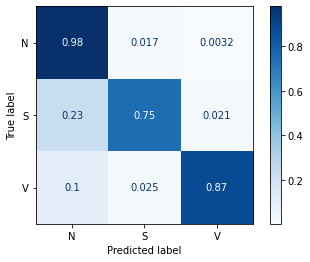

              precision    recall  f1-score   support

           N       0.99      0.98      0.98     90773
           S       0.63      0.75      0.69      3844
           V       0.88      0.87      0.88      3118

    accuracy                           0.97     97735
   macro avg       0.83      0.87      0.85     97735
weighted avg       0.97      0.97      0.97     97735



In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


cm = confusion_matrix(ytest_transformed, predictions, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[NORMAL, SUPER_VENTRICULAR, VENTRICULAR])
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(classification_report(ytest_transformed, predictions, target_names=['N', 'S', 'V']))